####Notes and Imports

#####Notes
- Using SimData_to_csv notebook to create dataset csv
- I may want a labels map (dict) for pipe labels like the one here
  - https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#iterating-and-visualizing-the-dataset
- Unclear what a one-hot encoded tensor might be used for
  - used here as a target label transformation
    - https://pytorch.org/tutorials/beginner/basics/transforms_tutorial.html#lambda-transforms

- How do I handle two labels?
- Is normalization required?
 - ans: desirable when features have different ranges. https://medium.com/@urvashilluniya/why-data-normalization-is-necessary-for-machine-learning-models-681b65a05029#:~:text=The%20goal%20of%20normalization%20is,when%20features%20have%20different%20ranges.
- Complete a panda tutorial
- He: Classifer tutorial; CIFAR10 dataset (3 channel images)
 - https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
- Colab Pro
 - One important caveat to remember while using Colab is that the files you upload to it won’t be available forever. Colab is a temporary environment with an idle timeout of 90 minutes and an absolute timeout of 12 hours. This means that the runtime will disconnect if it has remained idle for 90 minutes, or if it has been in use for 12 hours [longer for Colab Pro]. On disconnection, you lose all your variables, states, installed packages, and files and will be connected to an entirely new and clean environment on reconnecting. source:https://neptune.ai/blog/google-colab-dealing-with-files

In [1]:
# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#   print('Not connected to a GPU')
# else:
#   print(gpu_info)

# from psutil import virtual_memory
# ram_gb = virtual_memory().total / 1e9
# print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

# if ram_gb < 20:
#   print('Not using a high-RAM runtime')
# else:
#   print('You are using a high-RAM runtime!')

####Model framework

In [2]:
%matplotlib inline

import os
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms

import pandas as pd   # For loading csv file dataset
import random

import math   # Used for nan checking (math.isnan())
import numpy as np   # Used w/ pipe_to_pipeIdx file and graphics.
import pickle   # Used for loading reg_dict (stored w/ training data csv's; constructed in graph_partition notebook)

# Straight-Through Estimator
# https://www.hassanaskary.com/python/pytorch/deep%20learning/2020/09/19/intuitive-explanation-of-straight-through-estimators.html

# Autograd
# https://pytorch.org/tutorials/beginner/examples_autograd/two_layer_net_custom_function.html

# Define model
#  -- when called, model returns a output_dim dimensional tensor
# def sparseProbMap(batch_probMap, sparsity) :
def sparseProbMap(probMap, sparsity) :
  """Rescale probability map (batch_probMap) to obtain desired sparsity in
  measuremets that are turned on.
  sparsity = budget (int) / training sample length (meas)
    budget -- number of measurement to turn on/ sensor to deploy
  """
  mean = torch.mean(probMap, dim=0, keepdim=True)
  scalar = sparsity / mean
  beta_scalar = (1 - sparsity) / (1 - mean)
  toggle = torch.le(scalar, 1).float()
  sparse_probMap = ( toggle * scalar * probMap
                      + (1 - toggle) * (1 - (1 - probMap) * beta_scalar) )
  # print(f'sparseProbMap(): samp_means {samp_means}')
  # print(f'sparseProbMap(): samp_means size {samp_means.size()}')
  # print(f'sparseProbMap(): samp_scalars {samp_scalars}')
  # print(f'sparseProbMap(): samp_beta_scalars {samp_beta_scalars}')
  # print(f'sparseProbMap(): sparse_probMap size {sparse_probMap.size()}')
  return sparse_probMap
  
  # Alt approaches
  # torch method -- with prob_map repeat before this func call (i.e. batch_probMap)
  # Notice batch_probMap contains batch_size copies of one prob_map
  #  Might be able to make this even faster by running the calc once, then repeating after this call.
  # Tensor version -- might speed up training time.
  # samp_means = torch.mean(batch_probMap, dim=1, keepdim=True)
  # samp_scalars = sparsity / samp_means
  # samp_beta_scalars = (1 - sparsity) / (1 - samp_means)
  # toggles = torch.le(samp_scalars, 1).float()
  # sparse_probMap = ( toggles * samp_scalars * batch_probMap
  #                     + (1 - toggles) * (1 - (1 - batch_probMap) * samp_beta_scalars) )

  # for samp_probMap in batch_probMap :
  #   mean_sampProbMap = torch.mean(samp_probMap)
  #   scalar_sampProbMap = sparsity / mean_sampProbMap
  #   beta_scalar = (1 - sparsity) / (1 - mean_sampProbMap) # Rename variable to something more descriptive
  #   # print(f'sparseProbMap(): samp_probMap {samp_probMap}')
  #   # print(f'sparseProbMap(): samp_probMap size {samp_probMap.size()}')
  #   # print(f'sparseProbMap(): mean_sampProbMap {mean_sampProbMap}')
  #   # assert False
  #   toggle = torch.le(scalar_sampProbMap, 1).float()
  #   scaled_sampMap = ( toggle * scalar_sampProbMap * samp_probMap
  #                     + (1 - toggle) * (1 - (1-samp_probMap) * beta_scalar) ).reshape([1, -1])
  #   # print(f'sparseProbMap(): scaled_sampMap type {type(scaled_sampMap)}')
  #   if scaled_sampMaps == None :
  #     scaled_sampMaps = torch.cat((scaled_sampMap,), dim=0).to(device)
  #   else :
  #     scaled_sampMaps = torch.cat((scaled_sampMaps, scaled_sampMap,), dim=0).to(device)
  #   # scaled_sampMaps.append(toggle * scalar_sampProbMap * samp_probMap + (1 - toggle) * (1 - (1-samp_probMap) * beta_scalar))
  # # print(f'sparseProbMap(): scaled_sampMaps size {scaled_sampMaps.size()}')

  # NOTE: Dramatic slowdown after incorporating this function.
  #  May be due to use of for loop.
  # Use with scaled_sampMaps list version.
  # One big tensor. I'd prefer rows. Try adding brackets to append statement.
  # print(f'sparseProbMap(): sparse_probMap size {sparse_probMap.size()}')
  # sparse_probMap = torch.cat((scaled_sampMaps,), dim=0)
  # sparse_probMap  = sparse_probMap.reshape([batch_size, -1])
  # assert False
  # return scaled_sampMaps   # Equivalent to sparse_probMap for a batch.

class STEFunction(torch.autograd.Function) :
    """
    We can implement our own custom autograd Functions by subclassing
    torch.autograd.Function and implementing the forward and backward passes
    which operate on Tensors.
    """

    @staticmethod
    def forward(ctx, probability_mask) :
        """
        In the forward pass we receive a Tensor containing the input (prob_mask) and return
        a Tensor containing the output (binary_mask).
        ctx is a context object that can be used
        to stash information for backward computation. You can cache arbitrary
        objects for use in the backward pass using the ctx.save_for_backward method.
        """
        # Push probability map through a bernoulli sampling to create 0/1 mask.
        # Return mask.

        prob_mask_size = probability_mask.size()
        # print(f'STEFunc() forward(): prob_mask_size {prob_mask_size}')
        # print(f'STEFunc() forward(): batch_size {batch_size}')

        # Bernoulli sampling.
        # Sample from a uniform distribution.
        # uni_samples = probability_mask.new_empty(prob_mask_size).uniform_()
        uni_samples = probability_mask.new_empty(prob_mask_size).uniform_()
        # Bernoulli sampled binary mask.
        binary_mask = (probability_mask > uni_samples).float()
        # Note the different sizes of probability_mask and uni_sample. The
        #  following operation returns a tensor shaped like uni_sample.
        # Note: torch.bernoulli() is not usable because func return only the prob mask,
        #  but the uniform distributions samples are needed for gradient calcs.
        # bin_mask = torch.bernoulli(probablility_mask)
        # print(f'STEFunc() forward(): bin_mask_size {binary_mask.size()}')
        # print(f'STEFunc() forward(): probability_mask {probability_mask},\n\tuni_samples {uni_samples}')
        # assert False

        ctx.save_for_backward(probability_mask, uni_samples)
        return binary_mask
    
    @staticmethod
    def backward(ctx, grad_output) :
      # return F.hardtanh(grad_output)
      # SigDeriv graph: https://www.desmos.com/calculator/icbxupp3dh
      alpha = 1
      prob_mask, uni_samples = ctx.saved_tensors

      # Sigmoid function derivative
      grad_est = (alpha * torch.exp(-alpha * (prob_mask - uni_samples))
          / (1 + torch.exp(-alpha * (prob_mask - uni_samples))) ** 2)
          # / torch.exp(1 + -alpha * (prob_mask - uni_samples)) ** 2)
      return grad_est * grad_output

class StraightThroughEstimator(nn.Module) :
  def __init__(self) :
    # Consider moving probability map parameters here.
    #  If so, change STEFunction call.
    super(StraightThroughEstimator, self).__init__()
  
  def forward(self, probability_mask) :
    binary_mask = STEFunction.apply(probability_mask)
  # def forward(self, probability_mask, batch_size) :
    # binary_mask = STEFunction.apply(probability_mask, batch_size)
    return binary_mask

class Encoder(nn.Module):
    # Consider removing the default parameter values.
    def __init__(self, input_dim=0, output_dim=0):
        super(Encoder, self).__init__()
        self.flatten = nn.Flatten()
        # Note: nn.Sequential may take only a single argument. A tuple may work,
        #  but unclear if this is stable.
        self.binary_STE_stack = nn.Sequential(
            # Define the input dimensions
            # STE is placed at the bottleneck of the autoencoder.
            StraightThroughEstimator(),
        )
        # self.ste = StraightThroughEstimator()
        # self.steFunc = STEFunction().apply
        self.sparProbMapFunc = sparseProbMap
        unif_samp_tn = torch.zeros([input_dim]).uniform_()
        self.mask_params = nn.Parameter(unif_samp_tn)
        # fill_val_tn = torch.zeros([input_dim]).fill_(0.5)
        # self.mask_params = nn.Parameter(fill_val_tn)

    def forward(self, x):
        x = self.flatten(x)
        prob_mask = torch.sigmoid(self.mask_params)   # Ensures probabilities lie btwn (0, 1)
        batch_size = x.size()[0]
        # Used to create bin_mask for ea training sample.
        #  To switch to one bin_mask per batch, comment out the following line.
        # prob_mask = prob_mask.repeat(batch_size, 1)
        sparse_probMask = self.sparProbMapFunc(prob_mask, sparsity=0.012)
        sparse_probMask = sparse_probMask.repeat(batch_size, 1)
        # sparse_probMask = prob_mask.repeat(batch_size, 1)
        # Using a tuple input is problematic because the model expects a grad for all inputs to nn.Sequential.
        binary_mask = self.binary_STE_stack(sparse_probMask)
        # binary_mask = self.binary_STE_stack(prob_mask)
        # binary_mask = self.ste(prob_mask)
        # binary_mask = self.steFunc(prob_mask)
        # print(f'Encoder.forward(): prob_mask size {prob_mask.size()}')
        # print(f'Encoder.forward(): prob_mask size {prob_mask}')
        # assert False
        # print(x.size())
        # print(f'Encoder.forward(): mask_params {self.mask_params}')
        # print('Encoder.forward(): batch_size', batch_size)
        # print('Encoder.forward(): binary_mask', binary_mask)
        return x * binary_mask, binary_mask, self.mask_params

    # May or may not need to define the backward behavior of this class.
    # def backward(self, x):
    #     pass
    
class Decoder(nn.Module):
    def __init__(self, input_dim, output_dim):   # output_dim is not yet used.
        super(Decoder, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_lrelu_stack = nn.Sequential(
            # Define the input dimensions
            nn.Linear(input_dim, 512),
            # nn.Linear(input_dim, output_dim),
            nn.LeakyReLU(),
            # nn.Linear(512, 512),
            # nn.LeakyReLU(),
            # nn.Linear(512, 512),
            # nn.LeakyReLU(),
            # nn.Linear(512, 512),
            # nn.LeakyReLU(),
            # nn.Linear(512, 512),
            # nn.LeakyReLU(),
            # nn.Linear(512, 512),
            # nn.LeakyReLU(),
            # # Define the output dimensions
            nn.Linear(512, output_dim),
            nn.LeakyReLU(),
        )
        # Yisong: initialize the weights in the first layer, and the following layers will follow suit.
        # self.linear_lrelu_stack[0].weight.data /= 100.

    def forward(self, x):
        x = self.flatten(x)
        # print(x.size())
        logits = self.linear_lrelu_stack(x)
        return logits

class Autoencoder(nn.Module) :
    def __init__(self, input_dim, output_dim) :
        super(Autoencoder, self).__init__()
        # self.auto_stack = nn.Sequential(
        #     Encoder(input_dim, output_dim),
        #     Decoder(),
        # )
        self.encoder = Encoder(input_dim=input_dim)
        self.decoder = Decoder(input_dim, output_dim)

    def forward(self, x, binMaskSizeLs=[], encode=False, decode=False) :
        if encode :
            pass
        elif decode :
            pass
        else :
            # x = self.auto_stack(x)
            under_samp_meas, binary_mask, mask_params = self.encoder(x)
            # Working out what to do with the binary_mask -- i.e. if it will be fed to decoder or not.
            bin_mask_size = binary_mask.sum()
            batch_size = x.size()[0]
            # binMaskSizeLs.append(bin_mask_size)
            # print(f'AE forward(): avg binary_mask size {int(bin_mask_size / batch_size)}')
            # print(f'Auto.forward(): mask_params {mask_params}')
            x = self.decoder(under_samp_meas)
        return x, mask_params

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


In [3]:
# input_dim = 10
# init_tensor = torch.zeros([input_dim]).uniform_()
# print(init_tensor)
# p_mask = nn.Parameter(init_tensor)
# print(p_mask)
# ste = STEFunction()
# print(ste)
# masks = ste.forward(init_tensor, p_mask)
# a = torch.randn(1, 2, 3, 4)
# b = torch.randn(2, 2)
# print(a)
# print(a.size())
# print(a.view(1, 1, 2, 3, 2, 2))
# print(b)
# print(b * a.view(1, 1, 2, 3, 2, 2))

# Create a mask for each sample by first creating a uniform value tn of size
#  [batch_size, prob_mask_size], then 
# c = torch.zeros([10]).uniform_()
# print(c)
# tn = c.new_empty([3, 10]).uniform_()
# print(tn)
# bin_mask = (c > tn).float()
# print(bin_mask)
# End "Create a mask ..."

# print(c)
# mask = STEFunction.forward(c, c)   # Comment out ctx line.
# print(mask)   # OK
# module = StraightThroughEstimator()
# mask = module(c)
# print(mask)
# module1 = Encoder(input_dim=10)
# meas = torch.randint(100, (10,))
# print(meas)
# mask = module1(meas)
# print(mask)   # OK

####Training and Testing

In [4]:
def train_loop(dataloader, model, entrop_decay, loss_fn, optimizer, pToPIdxDict=None, epoch=0, mod=100):
    """
    pipIdx (for loop) is a tensor containing the pipe indices associated with a training leak scenario.
    pToPIdxDict is a dict that maps pipe names (str) to a tuple of (region, pipe_idx)
      used to determine number of rows.
    """
    size = len(dataloader.dataset)
    num_batches = len(dataloader)   # For avg training loss
    # print(f'train_loop(): dataset size: {size}')
    # print(f'train_loop(): num_batches: {num_batches}')
    train_loss, train_accuracy = 0, 0
    confusion_matrix = torch.zeros(len(pToPIdxDict), 4, dtype=torch.int16)   # Think of way to make # of regions automatic.
                                                                             # Maybe add a 'lengths' key, value: (pipe_ct, reg_ct)
    prevLoss = 100.
    for batch, (X, y, pipIdx) in enumerate(dataloader):
        # print(batch, X)
        # print(y)
        # print(pipIdx)
        X = X.to(device)
        y = y.to(device)
        # Compute prediction and loss
        pred, prob_params = model(X)  # params for flexibility; update sanity check
        # print(y.size())
        # print(pred.size())
        # print(pred)
        # print(prob_params)
        
        if (True) :
        # if (epoch < 100) :
          # prob_mask * X -> classifier -> pred
          # # print(f"mask_params {model.state_dict()['encoder.mask_params']}")
          # prob_params = model.state_dict()['encoder.mask_params']  # could be slower than passing the params out
          prob_map = torch.sigmoid(prob_params)   # Ensures values (probabilities) lie btwn (0, 1)
          splus = nn.functional.softplus(prob_params, -1)   # -log(1 + e^(-x)); careful with the sign when using in expressions.
          # print(splus[0], prob_params[0])   # Sanity check
          # print(torch.max(splus))
          # assert torch.max(splus) < 0
          # print(epoch)
          # loss_KL = ( (1 - prob_map) * torch.log(1 - prob_map) + prob_map * torch.log(prob_map) - torch.log(torch.tensor(0.5)) ).sum()
          # p_m = torch.where(prob_map > 0, prob_map, torch.tensor(0.001).to(device))
          # p_m = torch.where(prob_map < 1, prob_map, torch.tensor(0.999).to(device))
          # # print(f'p_m max {torch.max(p_m)}, min {torch.min(p_m)}')
          # # print(f'p_m range {torch.max(p_m) + abs(torch.min(p_m))}')
          # loss_KL = ( (1 - p_m) * torch.log(1 - p_m) + p_m * torch.log(p_m) - torch.log(torch.tensor(0.5)) ).sum()
          # # loss_KL = ( (1 - p_m) * torch.log(1 - p_m) + p_m * torch.log(p_m) ).sum()
          # loss_KL = lamb * ( (1 - prob_map) * torch.log(1 - prob_map) + prob_map * torch.log(prob_map) ).sum()
          # Natural log is the result of torch.log(...)
          loss_KL = ( (1 - prob_map) * ((-1)*prob_params + splus) + prob_map * splus - torch.log(torch.tensor(0.5)) ).sum()   # includes constant term
          # loss_KL = ( (1 - prob_map) * ((-1)*prob_params + splus) + prob_map * splus ).sum()
          # Dramatic change between including lamb and not may affect learning.
          lamb = torch.exp(torch.tensor(entrop_decay * epoch))
          # lamb = torch.exp(torch.tensor(-1/1*epoch))   # zeros around (very early) epochs; https://www.desmos.com/calculator/dem8eqibe6
          # lamb = torch.exp(torch.tensor(-1/25*epoch))   # zeros around 250 epochs; https://www.desmos.com/calculator/miayf0qrbe
          # lamb = torch.exp(torch.tensor(-1/100*epoch))   # zeros around 1000 epochs; https://www.desmos.com/calculator/dem8eqibe6
          # lamb = torch.exp(torch.tensor(-1/4000*epoch))   # zeros around 28k epochs; https://www.desmos.com/calculator/6fi4dfzuji
          # lamb = torch.exp(torch.tensor(-1/6000*epoch))   # zeros around 44k epochs; https://www.desmos.com/calculator/cwlhq5xe4n
          # lamb = torch.exp(torch.tensor(-1/10000*epoch))   # zeros around 70k epochs 
          # lamb = torch.exp(torch.tensor(-1/14000*epoch))   # zeros around 100k epochs # Try 1 / sqrt(epoch)   # Was using 1 / e^(-alpha*x) => e^(alpha*x) i.e. not what I wanted.
          # lamb = 1 / epoch
          loss_KL = lamb * loss_KL   # Anneal diversity loss
        else :
          loss_KL = 0.0
        # # print(f'loss_KL {loss_KL}')
        # # assert loss_KL != float('nan')
        # assert not math.isnan(loss_KL)

        # **** Notice pred is formed on the batch level, but loss_KL is a one shot ****
        loss = loss_fn(pred, y) + loss_KL  # returns single value; avg loss across batch
        # loss = loss_fn(pred, y)   # returns single value; avg loss across batch
        assert loss != float('nan')
        # loss = loss_fn(pred, y)  # returns single value; avg loss across batch

        # print(loss * len(y))
        # for i in range(len(y)) :
        #   print(pred[i])
        #   print(y[i])
        #   ls = loss_fn(pred[i], y[i])
        #   print(f'loss {i} {ls}')
        # print(y)
        # print(pred.argmax(1).type(y.dtype))

        # Confusion Matrix
        # (pipe label vs region) i.e. the resolution of the row is pipe name (not just region)
        # m(n, r)  where n is the cardinality of the leakpipe set, r is the number of regions
        # At the time of assignment,
        #  need a dict that maps pipe str to pipe idx
        #  the pipe label (str) (not the region label) for the training sample
        #  the model predicted region
        # preds = pred.argmax(1).type(y.dtype)
        # for i in range(len(y)) :
        #   confusion_matrix[pipIdx[i]][preds[i]] += 1
        # print(f'train_loop(): preds {preds}')
        # print(confusion_matrix)
        # print(f'train_loop(): conf_mat {confusion_matrix.size()}')
        # assert False
        # Older version of conf mat.
        # preds = pred.argmax(1).type(y.dtype)
        # for i in range(len(y)) :
        #   confusion_matrix[y[i]][preds[i]] += 1
        
        # Top-k predictions
        # torch.topk(input, k, dim=None, largest=True, sorted=True, *, out=None) -> (Tensor, LongTensor)
        # k = 1
        # top_k = torch.topk(input=pred, k=k, dim=1,)
        # print(top_k)

        # Disaggregate performance -- save model
        #  goal: extract outliers (in another notebook)
        #  Make into a function.
        # if epoch > 2000 and loss.item() > (prevLoss * 15) :
        # if epoch == 10000 :
        #   print(f'train_loop(): epoch {epoch} -- loss jumped from {prevLoss:.3} to {loss.item():.3}')
        #   torch.save(model.state_dict(), f'/content/drive/MyDrive/Colab Notebooks/Water Distribution Network/Decoder/saved_models/d11_epoch{epoch}_{batch}_{loss.item():.3}.pt')
        # # print(prevLoss)
        # prevLoss = loss.item()
        # print(prevLoss > loss * 20)
        # print(epoch)
        # assert False

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # train_loss += loss_fn(pred, y).item() * len(y)   # I think this second call to loss_fn runs the grad twice. ???
        train_loss += loss.item() * len(y)
        # y.dtype ensures the the operand types match for use w/ comparison operator (sensitive to type)
        train_accuracy += (pred.argmax(1).type(y.dtype) == y).type(torch.float32).sum().item()
        # print(loss)

        if batch % mod == 0:
            # print(batch)
            # print(y)
            # print(pred)
            loss, current = loss.item(), batch * len(X)
            # print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    # Save last model
    # if epoch == 10000 :
    #     print(f'train_loop(): epoch {epoch} -- loss jumped from {prevLoss:.3} to {loss.item():.3}')
    #     torch.save(model.state_dict(), f'/content/drive/MyDrive/Colab Notebooks/Water Distribution Network/Decoder/saved_models/d11_epoch{epoch}_{batch}_{loss.item():.3}.pt')

    train_loss /= size    # weighted avg training loss
    train_accuracy /= size
    print(f"Training Error: \n Accuracy: {(100*train_accuracy):>0.1f}%, Avg loss: {train_loss:>8f} \n")
    return train_loss, train_accuracy, confusion_matrix


def test_loop(dataloader, model, loss_fn, pToPIdxDict=None, out_dim=10):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    # print(f'test dataset size: {size}')
    # print(f'test num_batches: {num_batches}')
    test_loss, test_accuracy = 0, 0
    confusion_matrix = torch.zeros(len(pToPIdxDict), out_dim, dtype=torch.int32)

    with torch.no_grad():
        for X, y, pipIdx in dataloader:
            X = X.to(device)
            y = y.to(device)

            pred, _ = model(X)
            # print(pred)
            # print(y)
            test_loss += loss_fn(pred, y).item()
            # y.dtype ensures the the operand types match for use w/ comparison operator (sensitive to type)
            test_accuracy += (pred.argmax(1).type(y.dtype) == y).type(torch.float32).sum().item()
            # Confusion matrix
            preds = pred.argmax(1).type(y.dtype)
            for i in range(len(y)) :
              # confusion_matrix[y[i]][preds[i]] += 1
              confusion_matrix[pipIdx[i]][preds[i]] += 1
            # print(f'test_loop(): conf mat {confusion_matrix}')

    test_loss /= num_batches
    test_accuracy /= size
    print(f"Test Error: \n Accuracy: {(100*test_accuracy):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    # return test accuracy percentage for epoch
    return test_accuracy, confusion_matrix

####Animator (d2l)

In [5]:
def use_svg_display():
    """Use the svg format to display a plot in Jupyter."""
    display.set_matplotlib_formats('svg')

In [6]:
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib."""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

In [7]:
from matplotlib import pyplot as plt
from IPython import display   # Try commenting out. Maybe I'll be able to save image from print out (rather than files)

class Animator:
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
      
        self.nrows = nrows
        self.ncols = ncols
        self.figsize = figsize

        self.xlabel = xlabel
        self.ylabel = ylabel
        self.xlim = xlim
        self.ylim = ylim
        self.xscale = xscale
        self.yscale = yscale
        self.legend = legend

        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)

    
    def display_plt(self):
        # Borrowed use_svg_display() implementation from d2l
        use_svg_display()
        # matplot function
        self.fig, self.axes = plt.subplots(self.nrows, self.ncols, figsize=self.figsize)
        if self.nrows * self.ncols == 1:
            self.axes = [self.axes,]
        # Use a lambda function to capture arguments; set_axes in d2l API
        self.config_axes = lambda: set_axes(self.axes[0],
                                            self.xlabel,
                                            self.ylabel,
                                            self.xlim,
                                            self.ylim,
                                            self.xscale, self.yscale, self.legend)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

        # return self.fig

####Confusion Matrix

In [8]:
# %run /content/drive/MyDrive/'Colab Notebooks'/'Water Distribution Network'/'Input Pipeline'/'Data To File'/SimData_to_csv(hdf)_v1.ipynb

class Conf_Mat() :
  def __init__(self, classes=10) :
    """classes (int): the number of classes in the classifier."""
    self.confusion_matrix = torch.zeros(classes, classes, dtype=torch.int32)
    # Load labels via JSON or csv file.
    self.labels_str = ['P1', 'P10', 'P100', 'P1000', 'P101', 'P1016', 'P102', 'P20', 'P40', 'P1024']
  
  def addValues(self, pred, y) :
    """Add values to the confusion matrix.
    pred (tensor): tensor containing model predictions.
    y (tensor): tensor containing ground truth labels.
    return None
    """
    # Confusion Matrix
    for i in range(len(y)) :
      preds = pred.argmax(1).type(y.dtype)
      confusion_matrix[y[i]][preds[i]] += 1
    print(confusion_matrix)
  
  def displayConfMat(self) :
    pass

def decode_labels(regdict_filenm) :
  # Might be easier to place the encoder in a file and read it here.
  # WARNING: lab_subset order is not consistent.
  # NOTE: sets are not subscriptable
  # return sorted(['P1', 'P10', 'P100', 'P1000', 'P101', 'P1016', 'P102', 'P20', 'P40', 'P1024'])
  # regdict_dir = '/content/drive/MyDrive/Colab Notebooks/Water Distribution Network/Input Pipeline/Datasets/leak_pipes_all/39regions/00/'
  # file_nm = f'region_dict_{partitions}.pickle'
  load_loc = regdict_filenm

  # For loading
  with open(load_loc, 'rb') as handle:
      reg_dict = pickle.load(handle)
  
  prediction_labels = []
  for reg_nm in reg_dict['reg_partits'] :   # reg_partits is a dict; key: reg_nm (str), value: ls of pipe in region
    prediction_labels.append(reg_nm)
  return sorted(prediction_labels)   # sorted in lexiconic order. Not cosistent w/ conf_mat pred col order.
# print(decode_labels())   # For testing.

def leak_pipe_strs() :
  # Would like to develop an automatic method to transfer pipe names of labels (rather copy paste).
  #  In this noteboook, labels have been encoded (mapped) to a unique int in 
  # Copy-paste list of pipe names for labels here from simdata_to_csv notebook.
  return sorted({'P1', 'P10', 'P100', 'P1000', 'P101', 'P1016', 'P102', 'P1022',
                 'P1023', 'P1024', 'P1025', 'P1026', 'P1027', 'P1028', 'P1029', 
                 'P103', 'P1030', 'P1031', 'P1032', 'P1033', 'P1034', 'P1035', 
                 'P1036', 'P1039', 'P104', 'P1040', 'P1041', 'P1042', 'P1044', 
                 'P1045', 'P106', 'P107', 'P108', 'P109', 'P11', 'P110', 'P111', 
                 'P112', 'P113', 'P115', 'P116', 'P117', 'P118', 'P119', 'P12', 
                 'P120', 'P121', 'P122', 'P123', 'P124', 'P125', 'P126', 'P127', 
                 'P128', 'P129', 'P13', 'P130', 'P131', 'P132', 'P134', 'P136', 
                 'P138', 'P139', 'P14', 'P140', 'P141', 'P142', 'P144', 'P147', 
                 'P148', 'P15', 'P150', 'P154', 'P155', 'P156', 'P157', 'P158', 
                 'P159', 'P16', 'P160', 'P161', 'P162', 'P163', 'P165', 'P166', 
                 'P17', 'P174', 'P177', 'P18', 'P184', 'P19', 'P195', 'P2', 'P20', 
                 'P201', 'P21', 'P211', 'P215', 'P218', 'P219', 'P22', 'P220', 'P223', 
                 'P225', 'P228', 'P23', 'P230', 'P231', 'P233', 'P234', 'P235', 'P237', 
                 'P238', 'P24', 'P241', 'P242', 'P243', 'P245', 'P246', 'P248', 'P249', 
                 'P25', 'P251', 'P252', 'P255', 'P256', 'P258', 'P259', 'P26', 'P264', 
                 'P266', 'P267', 'P268', 'P27', 'P270', 'P272', 'P275', 'P28', 'P280', 
                 'P282', 'P284', 'P285', 'P286', 'P287', 'P288', 'P29', 'P290', 'P291', 
                 'P292', 'P293', 'P294', 'P295', 'P296', 'P297', 'P298', 'P299', 'P3', 
                 'P30', 'P301', 'P302', 'P303', 'P304', 'P305', 'P307', 'P308', 'P309', 'P31', 'P310', 'P316', 'P319', 'P32', 'P320', 'P322', 'P323', 'P329', 'P33', 'P330', 'P331', 'P336', 'P337', 'P338', 'P339', 'P34', 'P340', 'P341', 'P343', 'P344', 'P346', 'P347', 'P348', 'P349', 'P35', 'P350', 'P37', 'P372', 'P374', 'P375', 'P376', 'P378', 'P379', 'P38', 'P380', 'P381', 'P383', 'P384', 'P385', 'P386', 'P39', 'P397', 'P398', 'P399', 'P40', 'P402', 'P403', 'P409', 'P410', 'P42', 'P424', 'P43', 'P44', 'P443', 'P445', 'P446', 'P450', 'P46', 'P465', 'P467', 'P468', 'P48', 'P482', 'P484', 'P49', 'P492', 'P5', 'P500', 'P501', 'P502', 'P51', 'P510', 'P52', 'P524', 'P527', 'P529', 'P53', 'P54', 'P55', 'P57', 'P58', 'P596', 'P597', 'P6', 'P609', 'P610', 'P63', 'P633', 'P64', 'P65', 'P67', 'P670', 'P671', 'P68', 'P69', 'P697', 'P7', 'P70', 'P71', 'P72', 'P724', 'P725', 'P752', 'P753', 'P754', 'P755', 'P756', 'P757', 'P758', 'P759', 'P760', 'P761', 'P763', 'P766', 'P767', 'P768', 'P769', 'P771', 'P772', 'P775', 'P776', 'P777', 'P779', 'P780', 'P781', 'P783', 'P784', 'P785', 'P786', 'P787', 'P788', 'P789', 'P791', 'P794', 'P795', 'P796', 'P797', 'P798', 'P8', 'P800', 'P801', 'P804', 'P805', 'P806', 'P807', 'P808', 'P809', 'P810', 'P811', 'P813', 'P815', 'P817', 'P819', 'P821', 'P822', 'P823', 'P826', 'P827', 'P83', 'P830', 'P831', 'P84', 'P840', 'P841', 'P842', 'P844', 'P846', 'P847', 'P85', 'P850', 'P851', 'P852', 'P853', 'P855', 'P858', 'P859', 'P86', 'P861', 'P866', 'P87', 'P871', 'P880', 'P889', 'P89', 'P892', 'P9', 'P90', 'P91', 'P914', 'P915', 'P92', 'P924', 'P927', 'P929', 'P930', 'P931', 'P932', 'P933', 'P934', 'P935', 'P937', 'P938', 'P939', 'P94', 'P940', 'P941', 'P942', 'P943', 'P944', 'P946', 'P947', 'P948', 'P949', 'P95', 'P951', 'P953', 'P954', 'P955', 'P956', 'P957', 'P958', 'P959', 'P96', 'P961', 'P962', 'P963', 'P964', 'P965', 'P966', 'P967', 'P968', 'P969', 'P97', 'P970', 'P971', 'P972', 'P973', 'P974', 'P975', 'P976', 'P977', 'P978', 'P98', 'P981', 'P982', 'P983', 'P984', 'P986', 'P987', 'P988', 'P989', 'P99', 'P990', 'P991', 'P992', 'P993', 'P994', 'P995', 'P996', 'P997', 'P998', 'P999'})

####Normalization

In [9]:
def norm(features) :
  # print(f'norm(): {features} size {features.size()}')
  sq_feat = features ** 2
  # print(f'norm(): {sq_feat} size {sq_feat.size()}')
  sum_feat = sq_feat.sum(1)
  # print(f'norm(): {sum_feat} size {sum_feat.size()}')
  norm_feat = torch.sqrt(sum_feat)
  # print(f'norm(): {norm_feat} size {norm_feat.size()}')
  # print(norm_feat.view(features.size(0), 1))
  unit_feat = features / norm_feat.view(features.size(0), 1)
  # print(f'norm(): {unit_feat} size {unit_feat.size()}')
  return unit_feat
# _, observed, __ = SimData(net_char=4, tmstp=80)
# norm(observed)

####Subsampling

#####Mask Generation
- (1/0) Sensing Mask Vector

In [10]:
def sensing_mask_rand(feature_vec, max_sense = 30):
  """
  preconditions: feature tensor must be flat.

  Parameters
  feature_vec: feature tensor to be masked
   shape: list of dimensions
  max_sense: randomly choose 1 to max_sense to be 1, rest 0

  returns 0/1 sensing mask tensor of shape feature_vec w/ max_sense elems set to 1 (rest 0)
  """

  # Create (0/1) mask populated w/ max_sense ones
  mask = torch.zeros(feature_vec.size()).to(device)
  # print(mask)
  # indices = torch.randint(len(feature_vec), size=(max_sense,))   # may contain fewer than max_sense unique indices
  # Katie: Randomize indices and choose the first max_sense
  indices = [*range(len(feature_vec))]
  random.shuffle(indices)
  # print(indices)
  # for idx in indices:   # for use with line 16
  for idx in indices[:max_sense]:
    mask[idx] = 1
  # print(mask)

  # Pass features through the mask
  masked_features = feature_vec * mask

  return mask, masked_features.to(device)
# feature_vec = torch.rand([100])
# print(feature_vec)
# mask, masked_feats = sensing_mask_rand(feature_vec)
# print(mask, '\n', masked_feats)

In [11]:
def sensing_mask_alternate(feature_vec):
  """
  preconditions: feature tensor must be flat.

  Parameters
  feature_vec: feature tensor to be masked

  returns 0/1 sensing mask tensor of shape feature_vec w/ even indexed elems set to 1 (rest 0)
  """

  # Create (0/1) mask populated w/ max_sense ones
  mask = torch.zeros(feature_vec.size()).to(device)
  # print(mask)
  for idx in range(0, feature_vec.size()[0], 2) :
    mask[idx] = 1
  # print(mask)

  # Pass features through the mask
  # masked_features = feature_vec * mask

  # Simplification: This version reduces the size of the feature
  #  vector by half (mask not concat).
  masked_features = feature_vec[0].reshape([1])
  for idx in range(2, feature_vec.size()[0], 2) :
    masked_features = torch.cat((masked_features, feature_vec[idx].reshape([1])))

  return mask, masked_features.to(device)
# feature_vec = torch.rand([100]).to(device)
# print(feature_vec)
# mask, masked_feats = sensing_mask_alternate(feature_vec)
# print(mask, '\n', masked_feats.size(), '\n', masked_feats)

#####Random subsamples

In [12]:
def random_subset(meas_tensor, size, seed=None) :
  """Random subset of measurements (fixed seed).
  Must be able to change the cardinality of the subset.
  Algorithm
    create list of indices
    randomize indices
    select first x number of indices (where x is the subset cardinality)
    form a tensor containing the the sample measurements matching those indices.
    return this tensor
  """
  gen = None
  if seed :
    gen = torch.Generator().manual_seed(seed)

  rand_idxs = torch.randperm(meas_tensor.size()[0], generator=gen)
  sub_idxs = rand_idxs[:size]
  # print('random_subset():', sub_idxs, sub_idxs.size())
  subset = meas_tensor[sub_idxs]
  # print(meas_tensor.size())
  return subset.to(device), sub_idxs

# Test code
# X = torch.rand(100)
# rand_sub = random_subset(X, 50, 1000)
# print('random_subset results:', rand_sub)
# print(rand_sub.size())
# assert False

In [13]:
def rand_sub_dataset(X, size, seed=None) :
  reduced_meas_X = torch.zeros([X.size(0), size]).to(device)
  # print(X.size(0))
  for i in range(len(X)) :
    rand_sub, sub_idxs = random_subset(X[i], size, seed)
    # print('random_subset results:', rand_sub)
    # print(rand_sub.size())
    reduced_meas_X[i] = rand_sub
  return reduced_meas_X, sub_idxs

# Test Code
# X = torch.rand([3, 20])
# size, seed = 10, 1000
# reduced_meas_X, sub_idxs = rand_sub_dataset(X, size, seed)
# # print(sub_idxs)
# for i, idx in enumerate(sub_idxs) :
#   # print(reduced_meas_X[0, i], X[0, idx])
#   if reduced_meas_X[0, i].item() != X[0, idx].item() :
#     raise Exception('rand_sub_dataset(): Error: Value doesnt match.')
# # print(X[0, 307], X[0, 536], X[0, 329])
# # print(reduced_meas_X[0, 0], reduced_meas_X[0, 1], reduced_meas_X[0, 2])
# print('Done!')

####Load CSV (SimData) and form concat dataset

In [14]:
def SimData(net_char, dset_size, tmstp_path, tmstp) :
  """
  Note: Dataset file generated in SimData_to_csv notebook
   row 0: base_case
   rows 1->set_size: observed; one leak scenario per row; 1hr (out of one week)
    Labels included (last column); pipe index (second to last column) for use w/ conf mat
  """

  # Load dataframe
  # Moved file path assembly to filepaths(); centralizing input/output path update
  # src_dir = '/content/drive/MyDrive/Colab Notebooks/Water Distribution Network/Input Pipeline/Datasets/'
  # leak_pip_ct = 'all'
  # leak_pipes = f'leak_pipes_{leak_pip_ct}/'
  # regions = '39regions/00/'
  if tmstp :
    ts_dir = f'tmstp{tmstp}/'
  else :
    ts_dir = ''
  # # NOTE: double check dataset file name
  # dset_size = 5000
  # dataset_file = regions + ts_dir + f'dataset{dset_size}'
  dataset_file = ts_dir + f'dataset{dset_size}'
  areaLo, areaHi = 0.01, 0.1
  leak_area = f'area{areaLo}_{areaHi}'
  if net_char == 0:   dataset_file += f'_link_flowrate_{leak_area}.csv'
  elif net_char == 1: dataset_file += f'_link_headloss_{leak_area}.csv'
  elif net_char == 2: dataset_file += f'_link_velocity_{leak_area}.csv'
  elif net_char == 3: dataset_file += f'_node_demand_{leak_area}.csv'
  elif net_char == 4: dataset_file += f'_node_head_{leak_area}.csv'
  elif net_char == 5: dataset_file += f'_node_pressure_{leak_area}.csv'
  
  data_file = tmstp_path + dataset_file
  # print(data_file)
  # data_file = src_dir + leak_pipes + dataset_file
  datast_ds = pd.read_csv(data_file)
  # print(datast_ds.head())   # View csv data.
  
  # Separate base_case, raw_data, and encoded labels
  # Base Case
  # print(datast_ds.values[0, :-1].astype(np.float32))
  # print(type(datast_ds.values[0, :-1].astype(np.float32)))
  # base_case = torch.tensor(datast_ds.values[0, :-1], dtype=torch.float32).to(device)
  # base_case = torch.tensor(datast_ds.values[0, :-1].astype(np.float32), dtype=torch.float32).to(device)
  base_case = torch.tensor(datast_ds.values[0, :-2], dtype=torch.float32).to(device)   # Used w/ separate cols for pipeIdx and Label (no tuple)
  # print(base_case)
  # raw_data
  # raw_data = torch.tensor(datast_ds.values[1: , :-1], dtype=torch.float32).to(device)
  # raw_data = torch.tensor(datast_ds.values[1: , :-1].astype(np.float32), dtype=torch.float32).to(device)  # Had to add astype() when I added tuples in label col
  raw_data = torch.tensor(datast_ds.values[1: , :-2], dtype=torch.float32).to(device)   # Used w/ separate cols for pipeIdx and Label (no tuple)
  print(f'SimData(): raw_data {raw_data.size()}')
  # encoded labels
  # print(datast_ds['Label'][1])
  # print(type(datast_ds['Label'].astype('int')[1]))
  pipe_idxs = torch.tensor(datast_ds['PipeIdx'], dtype=torch.long)[1:].to(device)
  labels = torch.tensor(datast_ds['Label'], dtype=torch.long)[1:].to(device)
  # Possible implementation for pipe_idx (mapping of pipe_nms to pipe_idx done in simdata_to_csv notebook)
  #  Change base_case and raw_data to [1: , :-2]; the last two rows would contain pipe_idx and label values respectively.
  # pipe_idx = torch.tensor(datast_ds['Pipe_idx'], dtype=torch.long)[1:].to(device)
  print(f'SimData(): labels {labels.size()}')

  return base_case, raw_data, labels, pipe_idxs
# _, __, ___ = SimData(0, 80)

In [15]:
def leakpipe_subset(pipe_ct, raw, enc_labs):
  "Used to limit the number of pipes in the dataset"
  tmp_raw = torch.tensor([[0]]).to(device)   # dim trouble w/ cat
  tmp_labs = torch.tensor([0]).to(device)
  print(tmp_labs.size())

  for i in range(len(enc_labs)):
    if enc_labs[i] < pipe_ct:
      tmp_raw = torch.cat((tmp_raw, raw[i].reshape([444])))
      tmp_labs = torch.cat((tmp_labs, enc_labs[i].reshape([1])))

  return tmp_raw[1:], tmp_labs[1:]

In [16]:
def cat_net_attr(net_ls, dset_size, ts_path, tmstp, residual=False, norm_feats=False) :
  """Creates three flat vectors containing concatinations of each attribute's
       (1) base_case, (2) observed measurements, and (3) a single copy of label data (leak labels for all attrs are the same).
     **If residual is true, don't use norm here.**
     """
  cat_attrs = None
  for net_char in net_ls :
    # base_case, X_raw, encoded_labels
    data = SimData(net_char, dset_size, ts_path, tmstp)
    data_ls = list(data)   # Creates 3 elem list from data 3-tuple returned by SimData.

    if residual :   # Residual before normalization of features.
      data_ls[1] -= data_ls[0]
    # print(data_ls[1])
    # assert False
    if norm_feats :   # Normalize each attribute data separtely before cat.
      data_ls[1] = norm(data_ls[1])

    if not cat_attrs :
      cat_attrs = data_ls   # Includes labels. Only needed once.
    else :
      cat_attrs[0] = torch.cat((cat_attrs[0], data_ls[0]))  # Update base_case by cat'ing next net_attr.
      cat_attrs[1] = torch.cat((cat_attrs[1], data_ls[1]), dim=1)   # Update features by cat'ing next net_attr.
      # only need one set of label; no need to cat those again.
    # Normalize Features -- all together (i.e. if more than one attribute is cat'ed, all will be norm'ed together)
    # if norm_feats:
      # Raw data normed across all samples
      #  Would it make more sense to normalize ea sample individually?
      # X_raw = torch.nn.functional.normalize(X_raw, dim=0)
      # cat_attrs[1] = norm(cat_attrs[1])
  print(f'cat_net_attr(): Base {cat_attrs[0].size()}, X {cat_attrs[1].size()}, Labels {cat_attrs[2].size()}')
  return cat_attrs   # cat_attrs is a list (of tensors), but can be expanded by the caller.
# _, __, ___ = cat_net_attr([0, 4], 80, True)
# print(_.size(), __.size(), ___.size())
# assert False

In [17]:
def cat_data(residual=False, norm_base=False, norm_feats=False, mask=False, net_char=[0], dset_size=-1, ts_path=None, tmstp=None) :
  """Idea: pass list of tmstps to this function, for loop the list to create a training set w/ training samples from mult tmstps.
  """
  if isinstance(net_char, int) :
    net_char = [net_char]
  
  n_fs = norm_feats
  if residual :
    n_fs = False
  
  # Consider writing a script that automates both pulling mult tmstps of sim data together, but also cats features
  #  or perhaps just a dataset constructor script where multiple tmstps can be assembled into a single training set.
  base_case, X_raw, encoded_labels, pipIdxs = cat_net_attr(net_char, dset_size, ts_path, tmstp, residual, norm_feats=n_fs)   # Don't norm_feat in cat_net_attr if residual is true.
  # base_case, X_raw, encoded_labels = SimData(net_char, tmstp)
  print(f'cat_data(): X_raw max {torch.max(X_raw)}, min {torch.min(X_raw)}')
  print(f'cat_data(): X_raw range {torch.max(X_raw) + abs(torch.min(X_raw))}')
  print(f'cat_data(): X_raw {X_raw.size()}')
  # print(f'cat_data(): X_raw {X_raw[0]}')
  # print(f'cat_data(): base_case {base_case}')
  # print(f'cat_data(): pipe_idxs {encoded_labels}')
  
  # work in progress
  # X_raw, encoded_labels = leakpipe_subset(10, X_raw, encoded_labels)
  # print(f'cat_data: encoded labels \n{encoded_labels}')
  # print(f'cat_data: encoded labels {encoded_labels.size()}')

  # X_cat = None
  # norm_str = ''   # Used for debug output
  # Residual -- handled in cat_net_data
  # div_by_base = base_case   # What is this used for?
  # if residual:
    # Avoid dividing by zero
    # for idx in range(len(base_case)):
      # if base_case[idx] < 1.0e-12:
      #   div_by_base[idx] = 1.0e-10
    # X_raw = X_raw / div_by_base
    # X_raw -= base_case
    # base_case /= base_case   # might divide by zero
    # pass
  # print(f'cat_data(): X_raw {X_raw[0]}')
  
  # Normalizations
  #  Not sure this code is doing anything as X_raw has already been formed.
  if norm_base:
    # Normalize base_case
    #  orders of magnitude larger than residual data
    #  v = v / max(||v||_p, epsilon)  where epsilon is a small value that void dividing by zero
    # norm_base_case = torch.nn.functional.normalize(base_case.reshape([1,-1]))
    base_case = torch.nn.functional.normalize(base_case, dim=0) * 10.0   # Out-dated, use with caution.
    norm_str = 'norm_'
  # if norm_feats:
  #   # Raw data normed across all samples
  #   #  Would it make more sense to normalize ea sample individually?
  #   # X_raw = torch.nn.functional.normalize(X_raw, dim=0)
  #   X_raw = norm(X_raw)
  # print(f'cat_data(): {norm_str}base_case {base_case.size()}')
  # # print(f'cat_data(): {norm_str}base_case {base_case}')

  # print(X_raw[0])   # X_raw elements are already a flat tensor.
  # I think I can move if mask outer and elim the for loop.
  # for feature_vec in X_raw:
  #   if mask :
  #     # Mask and masked features
  #     #  May want sensing_mask_rand() that can process batches of samples
  #     # mask_tn, masked_feats = sensing_mask_rand(feature_vec)
  #     # Construct feature set from concatination of base_case, mask, and masked measuremnts.
  #     # temp = torch.cat((masked_feats.to(device), mask.to(device), base_case.to(device))).reshape([1,-1])
  #     # base_case measurements not included
  #     # temp = torch.cat((masked_feats.to(device), mask_tn.to(device))).reshape([1, -1])
  #     # Simplification: notice feature vector size is halved. Update col variable accordingly.
  #     mask_tn, masked_feats = sensing_mask_alternate(feature_vec)
  #     # Not Needed. Adjust size of label vector.
  #     # masked_labels = encoded_labels[0].reshape([1])
  #     # print(encoded_labels.size())
  #     # assert False
  #     # for idx in range(2, encoded_labels.size()[0], 2) :
  #     #   masked_labels = torch.cat((masked_labels, encoded_labels[idx].reshape([1])))
  #     temp = masked_feats.reshape([1,-1])
  #     # encoded_labels = masked_labels
  #     # print(f'cat_data(), mask: enc_lab size {encoded_labels.size()}')

  #   else :
  #     # Features (no mask)
  #     # Construct feature set from concatination of base_case and observed measuremnts.
  #     # temp = torch.cat((feature_vec.to(device), base_case.to(device))).reshape([1,-1])
  #     # I don't think this is doing anything.  Check if X_raw is changed by this. May already be a flat tensor after cat_net_attrs call.
  #     temp = feature_vec.reshape([1,-1])   # Tensor containing a tensor. Not sure that's needed.
  #   # print(f'cat_data(): temp {temp}')

    # if X_cat is None:
    #   X_cat = temp
    #   # print(X_cat)
    # else:  
    #   X_cat = torch.cat((X_cat, temp))
    #   # print(X_cat)

  # print(f'cat_data(): X_cat {X_cat.size()}')
  # print(f'cat_data(): X_cat {X_cat[0]}')
  # assert False
  # return X_cat, encoded_labels   # Not returning base_case at this time.
  return X_raw, encoded_labels, pipIdxs   # Not returning base_case at this time.
# print(f'output: {cat_data(residual=True, norm_base=False, norm_feats=False, mask=False)}')
# assert False

In [18]:
def cat_data_mult_tmstps(residual=False, norm_base=False, norm_feats=False, mask=False, net_char=[0], dset_size=-1, ts_path=None, tmstps=None) :
  """This func wraps cat_data() to concat traning samples from multiple time stamps.
  Notice tmstps is a list of time stamps to be included in the training set
      tmstps can include one time stamp to mimic previouis version, but must be in a list.
  """
  X_raw, encoded_labels, pipIdxs = None, None, None

  for tmstp in tmstps :
    X_r, enc_labs, pipIds = cat_data(residual, norm_base, norm_feats, mask, net_char, dset_size, ts_path, tmstp)
    if X_raw is None :
      X_raw = torch.cat([X_r])
      encoded_labels = torch.cat([enc_labs])
      pipIdxs = torch.cat([pipIds])
    else :
      X_raw = torch.cat([X_raw, X_r])
      encoded_labels = torch.cat([encoded_labels, enc_labs])
      pipIdxs = torch.cat([pipIdxs, pipIds])
  # print(f'X_raw {X_raw.size()}')
  # assert False

  return X_raw, encoded_labels, pipIdxs

####Train the model

#####Set-up Training

In [19]:
def filepaths() :
  """Consider splitting input and output paths into two separate functions.
  """
  ## Inputs
  partitions = 20
  leak_pip_ct = 'all'
  leak_pipes = f'leak_pipes_{leak_pip_ct}/'

  src_dir = '/content/drive/MyDrive/Colab Notebooks/Water Distribution Network/'
  reg_dir = src_dir + f'Input Pipeline/Datasets/' + leak_pipes + f'{partitions}regions/'
  version_dir = reg_dir + '00/'

  #  file path in Confusion Matrix cell; decode_labels(); region_dict_xx.pickle
  file_nm = f'region_dict_{partitions}.pickle'
  regdict_filenm = version_dir + file_nm

  #  file path in SimData(); dest path from step 3
  tmstp_path = version_dir
  # NOTE: double check dataset file name
  dset_size = 5000

  #  file path in Training setup and loop cell; pipe to pipe_idx.npy
  pToPId_dir = version_dir
  file_nm = 'dictPipeToPipeIdx.npy'
  pToPIdx_filenm = pToPId_dir + file_nm
  ## -------------- ##

  ## Outputs
  analy_dir = src_dir + f'Analysis/{partitions}regions/'
  download_dir = analy_dir + f'download_{partitions}regs/'

  #  file path in Training setup and loop cell; display_of_sensor_grid.pt
  sensgrid_filenm = analy_dir + f'display_of_sensor_grid.pt'

  #  file paths (3) in Graphics cell; loss.png, conf.png, conf_mat.pt
  conf_mat_filenm = analy_dir + 'conf_mat.pt'
  loss_filenm = download_dir + 'loss.png'
  conf_filenm = download_dir + 'conf.png'
  ## -------------- ##

  return partitions, regdict_filenm, tmstp_path, dset_size, pToPIdx_filenm, sensgrid_filenm, loss_filenm, conf_filenm, conf_mat_filenm

In [20]:
rows = 0
cols = 0
input_dim = 0
output_dim = 0

tr_dataset = None
ts_dataset = None

In [21]:
from collections import Counter
import statistics as stats

def histo_pipe_dist(labels) :
  """Display histogram of leakpipe distribution.
  labels (tensor) : pytorch tensor of labels (ints).
  Note: requires matplotlib and Pandas.
  """
  # Histo
  Y = pd.Series(labels.cpu())
  recounted = Counter(Y)
  print(recounted)
  std = stats.stdev(recounted.values())
  print(f'stdev {std:.2}')
  Y.plot.hist(grid=True, bins=10, alpha=0.7, rwidth=0.8, color='#607c8e', align='mid')
  plt.title(f'Label Frequency for {len(Y)} Samples')
  plt.xlabel('Label')
  plt.grid(axis='x')
  # plt.text(6, 200, r'class 5 = 229 (46%)')
  # assert False
  return std

In [22]:
def randomize_dataset(X, y) :
  random.seed(10343)
  ls = []
  for i in range(len(y)) :
    zipped = X[i], y[i]
    # print(zipped, end=" ")
    ls.append(zipped)
  # print('randomize_dataset(): ls', len(ls))
  random.shuffle(ls)
  shuf_X = torch.empty([1, len(X[0])]).to(device)
  # print(shuf_X.size(), shuf_X)
  shuf_y = torch.empty([1], dtype=torch.long).to(device)
  # print(shuf_X.size(), shuf_X)
  for feat, label in ls :
    # print('randomize_dataset(): feat', feat.reshape([1, -1]).size())
    shuf_X = torch.cat((shuf_X, feat.reshape([1, -1])))
    # print('randomize_dataset(): label', label.reshape([1]).size())
    # label = torch.tensor(label, dtype=torch.long).to(device)
    shuf_y = torch.cat( (shuf_y, label.reshape([1])) )
  # print(shuf_X)
  # print(shuf_y)
  # print('randomize_dataset(): shuf_X', shuf_X.size())
  # print('randomize_dataset(): shuf_y', shuf_y.size())
  return shuf_X[1:], shuf_y[1:]

In [23]:
def find_seed(X, y, tr_size, tr_or_ts) :
  min_std = 1e9
  # tr_or_ts = 0  # tr = 0, ts = 1
  for i in range(20, 150) :
    print(i)
    subsets = torch.utils.data.random_split(TensorDataset(X, y),
                                            [tr_size, len(y) - tr_size],
                                            generator=torch.Generator().manual_seed(i),
                                            )
    # print(len(subsets),
    #       subsets[1].dataset.tensors[1].size(),
    #       type(subsets[1].indices),
    #       len(subsets[1].indices),
    #       subsets[1].dataset.tensors[1][[i for i in subsets[1].indices]],
    #       )
    std = histo_pipe_dist(subsets[tr_or_ts].dataset.tensors[1][[i for i in subsets[tr_or_ts].indices]])
    if std < min_std :
      min_std = std
      seed = i
  print(f'Seed Found: argmin_stdev {seed}\n')
  return seed

#####MNISTfashion set

In [24]:
# mnist
"""
tr_dataset = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

ts_dataset = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

rows = 28
cols = 28
input_dim = rows*cols
output_dim = 10

learning_rate = 1e-3
epochs = 10
batch_size = 64
mod = 100
#"""

'\ntr_dataset = datasets.FashionMNIST(\n    root="data",\n    train=True,\n    download=True,\n    transform=transforms.ToTensor()\n)\n\nts_dataset = datasets.FashionMNIST(\n    root="data",\n    train=False,\n    download=True,\n    transform=transforms.ToTensor()\n)\n\nrows = 28\ncols = 28\ninput_dim = rows*cols\noutput_dim = 10\n\nlearning_rate = 1e-3\nepochs = 10\nbatch_size = 64\nmod = 100\n#'

#####CSV data Loading

SimData(): raw_data torch.Size([5000, 444])
SimData(): labels torch.Size([5000])
SimData(): raw_data torch.Size([5000, 396])
SimData(): labels torch.Size([5000])
cat_net_attr(): Base torch.Size([840]), X torch.Size([5000, 840]), Labels torch.Size([5000])
cat_data(): X_raw max 43.62644958496094, min -23.13990020751953
cat_data(): X_raw range 66.76634979248047
cat_data(): X_raw torch.Size([5000, 840])
SimData(): raw_data torch.Size([5000, 444])
SimData(): labels torch.Size([5000])
SimData(): raw_data torch.Size([5000, 396])
SimData(): labels torch.Size([5000])
cat_net_attr(): Base torch.Size([840]), X torch.Size([5000, 840]), Labels torch.Size([5000])
cat_data(): X_raw max 41.52079772949219, min -26.361465454101562
cat_data(): X_raw range 67.88226318359375
cat_data(): X_raw torch.Size([5000, 840])
SimData(): raw_data torch.Size([5000, 444])
SimData(): labels torch.Size([5000])
SimData(): raw_data torch.Size([5000, 396])
SimData(): labels torch.Size([5000])
cat_net_attr(): Base torch.Size

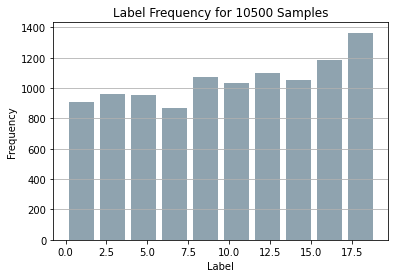

In [25]:
# Network characterist options:
#  {0: '/link_flowrate', 1: '/link_headloss', 2: '/link_velocity',
#   3: '/node_demand', 4: '/node_head', 5: '/node_pressure'}
### Centralize file paths; update them all from here; pass them along through func calls.
###   Hunting for things to update is tedious.
residual = True  # Subtract measured from base_case; 0 if normal behavior, else non-zero.
norm_base = False
norm_feats = True   
mask = False
net_char = 0
tmstps = [80, 81, 82]
# tmstps = [78, 79, 80, 81, 82, 83, 84, 85]
entrop_decay = -1/1
cat_attrs = True
subsample = False
if cat_attrs :
  net_char = [0, 4]
# Update filepaths() when changing meta parameters outside this notebook (e.g. number of regions has changed)
(partit_cnt, regdict_filenm, ts_path, dset_size, pToPIdx_filenm,
    sensgrid_filenm, loss_filenm, conf_filenm, conf_mat_filenm) = filepaths()

# print(regdict_filenm, ts_path, dset_size, pToPIdx_filenm,
#     sensgrid_filenm, loss_filenm, conf_filenm, conf_mat_filenm)
# assert False

# Training data is loaded from csv file constructed in SimData_to_cvs script.
# For single tmstp:
# X, y, pipIdx = cat_data(residual, norm_base, norm_feats, mask, net_char, tmstp)
# For mult tmstp (requires list of tmstps):
X, y, pipIdx = cat_data_mult_tmstps(residual, norm_base, norm_feats, mask, net_char, dset_size, ts_path, tmstps)
# print(y)
# print(pipIdx)
print(f'X size: {X.size()}')
# torch.set_printoptions(edgeitems=50)
# print(f'Training Set: X[0] {X[0]}')

if subsample :
  perc_of_meas = 0.01
  size = int(X.size(1) * perc_of_meas)
  print('subsample: size ', size)
  seed = 1001
  reduced_meas_X, __ = rand_sub_dataset(X, size, seed)
  print('subsample:', reduced_meas_X.size())
  # print(X[0, 307], X[0, 536], X[0, 329])
  # print(reduced_meas_X[0, 0], reduced_meas_X[0, 1], reduced_meas_X[0, 2])
  X = reduced_meas_X

torch.set_printoptions(edgeitems=3)
tr_size = int(len(X)*0.7)
ts_size = len(y) - tr_size
# tr_dataset = TensorDataset(X[:split_idx], y[:split_idx])
# ts_dataset = TensorDataset(X[split_idx:], y[split_idx:])
# Find a seed that creates a training set pipe distribution with smallest stdev.
seed = 69   # find_seed prints and returns best seed.
# seed = find_seed(X, y, tr_size, 0)   # Commented out to eliminate the overhead of looking for a seed everytime.
# assert False
# Two ways to deal w/ pipe labels
#  1. add a third element to the datasets (done here)
#  2. make y a tuple and decompose in training/test loop
tr_dataset, ts_dataset = torch.utils.data.random_split(TensorDataset(X, y, pipIdx),
                                        [tr_size, ts_size],
                                        generator=torch.Generator().manual_seed(seed),
                                        )

# Visualize the dataset leak pipe distribution.
# X, y = randomize_dataset(X, y)
# histo_pipe_dist(y[:split_idx])
# histo_pipe_dist(y[split_idx:])
idx = tr_dataset.indices
histo_pipe_dist(tr_dataset.dataset.tensors[1][[i for i in idx]])

# Determine learning rate and measurement vector size
if net_char == 0:
  # link_flowrate
  cols = 444   # links = 444; junctions = 396
  # learning_rate = 9e-3   # single layer
  learning_rate = 8e-2
if net_char == 2:
  # link_velocity
  cols = 444   # links = 444; junctions = 396
  learning_rate = 2e-7
elif net_char == 3:
  # node_demand
  cols = 396   # links = 444; junctions = 396
  learning_rate = 2e-6
  epochs = 2000
elif net_char == 4:
  # node_head
  cols = 396   # links = 444; junctions = 396
  learning_rate = 7e-2
  epochs = 2000
elif net_char == 5:
  # node_pressure
  cols = 396   # links = 444; junctions = 396
  learning_rate = 1e-3
elif isinstance(net_char, list) :
  if norm_feats and cat_attrs :
    learning_rate = 2e-2
  else :
    learning_rate = 8e-2   #(f, h, nf, nh, f+h)

# Determine number of concatenated vectors. Used for determining input_dim
concats = 1
if mask :
  concats = 1

elif norm_feats :
  pass
# Simplification adjustments
cols = X.size(1)
print(f'cols {cols}')

# Use region_dict to assign output_dim (i.e. # of regions)
rows = 1
input_dim = rows*cols*concats
output_dim = partit_cnt
epochs = 10000
# epochs = 50   # For testing.
batch_size = 128
mod = 5

# Instantiate model framework
model = Autoencoder(input_dim, output_dim).to(device)
print(model)
# print(*model.parameters())
# print(f"mask_params {model.state_dict()['encoder.mask_params'].size()}")
# assert False

#####Training

In [ ]:
# Training setup and loop

# Initialize the loss function
#  nn.CrossEntropyLoss() encapsulates nn.LogSoftmax and nn.NLLLoss
loss_fn = nn.CrossEntropyLoss()
# Parameter adjustment protocol
# He: always start w/ Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# For plotting results
animator = Animator(xlabel='epoch', xlim=[1, epochs], ylim=[0.0, 1.0],
                        legend=['train loss', 'train acc', 'test acc'])
binMaskSizeLs = []

# Load pipe_to_pipeidx numpy file (for use w/ confussion matrix)
pToPIdx_dic = np.load(pToPIdx_filenm, allow_pickle='TRUE').item()   # pToPIdx_filenm from filepaths() call above.
# print(f'pToPIdx dict: {pToPIdx_dic}')
# print(len(pToPIdx_dic))   # dicts have lengths.

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_dataloader = DataLoader(tr_dataset, batch_size=batch_size, shuffle=False)
    # for x,y in train_dataloader:
    #   print(x,y)
    #   break
    tr_loss, __, _ConfM_ = train_loop(train_dataloader, model, entrop_decay, loss_fn, optimizer, pToPIdx_dic, epoch=t+1, mod=mod)
    # tr_loss, __, _ConfM_ = train_loop(train_dataloader, model, loss_fn, optimizer, epoch=t+1, mod=mod)
    train_metrics = (tr_loss, __)

    test_dataloader = DataLoader(ts_dataset, batch_size=batch_size)
    test_acc, confusion_matrix = test_loop(test_dataloader, model, loss_fn, pToPIdx_dic, out_dim=output_dim)
    # animator
    animator.add(t + 1, train_metrics + (test_acc,))
# torch.save(model.state_dict(), f'/content/drive/MyDrive/Colab Notebooks/Water Distribution Network/Analysis/display_of_sensor_grid.pt')
torch.save(model.state_dict(), sensgrid_filenm)   # sensgrid_filenm from filepaths() call above.
# Not sure the following block is necessary
# train_loss, train_acc = train_metrics
# assert train_loss < 0.5, train_loss
# assert train_acc <= 1 and train_acc > 0.7, train_acc
# assert test_acc <= 1 and test_acc > 0.7, test_acc
print("Done!")

Streaming output truncated to the last 5000 lines.
Test Error: 
 Accuracy: 57.2%, Avg loss: 1.255238 

Epoch 6081
-------------------------------
Training Error: 
 Accuracy: 59.6%, Avg loss: 1.084650 

Test Error: 
 Accuracy: 55.9%, Avg loss: 1.304765 

Epoch 6082
-------------------------------
Training Error: 
 Accuracy: 59.3%, Avg loss: 1.100023 

Test Error: 
 Accuracy: 56.3%, Avg loss: 1.209516 

Epoch 6083
-------------------------------
Training Error: 
 Accuracy: 58.6%, Avg loss: 1.108187 

Test Error: 
 Accuracy: 55.6%, Avg loss: 1.214078 

Epoch 6084
-------------------------------
Training Error: 
 Accuracy: 60.4%, Avg loss: 1.092147 

Test Error: 
 Accuracy: 57.0%, Avg loss: 1.178058 

Epoch 6085
-------------------------------
Training Error: 
 Accuracy: 59.3%, Avg loss: 1.068509 

Test Error: 
 Accuracy: 57.0%, Avg loss: 1.173414 

Epoch 6086
-------------------------------
Training Error: 
 Accuracy: 60.3%, Avg loss: 1.070742 

Test Error: 
 Accuracy: 56.2%, Avg loss: 1.

In [ ]:
# Graphics

# %matplotlib inline
animator.display_plt()
# Save to file that is replaced on every run.
animator.fig.savefig(loss_filenm, bbox_inches='tight')   # loss_filenm from filepath() call above.
# Automate improved filename description.
# animator.fig.savefig('loss.png', bbox_inches='tight')
# plt.savefig('loss.png', bbox_inches='tight')   # Less specific. Targets active figure.

# Pipe labels (strings) are located in simdata_to_csv notebook
predictions = [f'{i}' for i in range(output_dim)]
# predictions = decode_labels(regdict_filenm)   # May no longer need to maintain regdict_filenm input path or decode_labels()
#                                 # Ordered pipe names is lexiconic and not consistent w/ conf mat (regions in number order)
# print(predictions)
# labels = range(output_dim)
# labels = decode_labels(regdict_filenm)
# print(ts_dataset[:][2])
# print(len(ts_dataset[:][2]))
# temp = [x.item() for x in ts_dataset[:][2]]
# print(temp)
# print(len(temp))
# labels = sorted(set(temp))
labels = [i for i in range(len(pToPIdx_dic))]
# print(labels)
# print(len(labels))
fig, ax = plt.subplots(1, 1, figsize=(100,100))
# fig.set_facecolor('#7d7f7c')
im = ax.imshow(confusion_matrix)
ax.set_xticks(np.arange(len(predictions)))
ax.set_yticks(np.arange(len(labels)))
# ax.set_xticklabels(predictions)
# ax.set_yticklabels(labels)

# Set-up for white grid lines on minor ticks. Creates spacing effect.
ax.set_xticks(np.arange(len(predictions)+1) - 0.5, minor=True)
ax.set_yticks(np.arange(len(labels)+1) - 0.5, minor=True)
# Print white grid to space out the squares.
ax.grid(which="minor", color="w", linestyle='-', linewidth=1)
# Remove spines for clarity.
for k, v in ax.spines.items() :
  v.set_visible(False)
# ax.spines['top'].set_visible(False)   # Can't slice a dictionary.
ax.tick_params(which="minor", bottom=False, left=False)

# Horizontal labeling displays on top
ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)
# Rotate tick labels and set alignment.
plt.setp(ax.get_xticklabels(), rotation=-45, ha='right', rotation_mode='anchor')
plt.xlabel(f'Predictions -- {ts_size}')
# Move the x labels to the top
ax.xaxis.set_label_position('top')
plt.ylabel('Labels')
# Annotate matrix with values by looping over data dimensions
for i in range(len(labels)) :
  for j in range(len(predictions)) :
    text = ax.text(j, i, confusion_matrix[i, j].item(),
                   ha='center', va='center', color='white')

ax.set_title(f'Confusion Matrix -- Epoch {t+1}')
fig.tight_layout()
# Save to file that is replaced on every run.
fig.savefig(conf_filenm)   # conf_filenm from filepath() call above.
torch.save(confusion_matrix, conf_mat_filenm)   # conf_mat_filenm from filepath() call above.
# plt.show()
# plt.close()

####Sanity Check: Pass a sample to the model

In [ ]:
def predict_ch3(net, sample, samp_idx=0):
    """Predict labels (redefined from d2l Chapter 3.6.7)."""
    print('Model Evaluation')
    X, y, pipId = sample[samp_idx]
    X = X.reshape([1,-1])
    preds = net(X)[0].argmax(axis=1)   # net returns a tuple of preds and prob_params
    print(f'Scenario {samp_idx} (pred={preds.item()}, label={y.item()})')

predict_ch3(model, tr_dataset, samp_idx=28)

In [ ]:
# Test trained model on time stamps it hasn't seen before
# tmstp = 168
# X, y = cat_data(residual, norm_base, norm_feats, mask, net_char, tmstp)
# ts_dataset = TensorDataset(X, y)

# test_dataloader = DataLoader(ts_dataset, batch_size=batch_size)
# test_acc = test_loop(test_dataloader, model, loss_fn)

####Scratch Work

In [ ]:
# catting to an empty tensor -- doesn't work
ls = [1, 2, 3]
tsr = torch.Tensor(ls)
print(tsr)
tsr1 = torch.ones([2,2])
print(tsr1)
tsr = torch.concat([tsr1])
print(tsr)
test = None
if test is None :
  print('is None!')

In [ ]:
print(0.991 > 0.99)
x = torch.rand(5)
print(x)
y = torch.where(x > 0.6, x, torch.tensor(0.))
print(y)

In [ ]:
import math
x = float('nan')
print(x)
print(not math.isnan(x))
print(1 + 0.0 * x)
print(torch.log(torch.tensor(0.0)))

In [ ]:
x_tup = ([2], [3], [4])
# x_tup = (2, 3, 4)
x_tup[1][0] -= x_tup[0][0]
# x_tup[1] -= x_tup[0]
# print(x_tup[1] - x_tup[0])
print(x_tup[1])

In [ ]:
t = torch.rand(10, generator=torch.Generator().manual_seed(10))
print(t)
t1 = torch.rand(10, generator=torch.Generator().manual_seed(11))
print(t1)
print(t[t1 > 0.5])   # returns a tensor containing only those elems for which test returns true.
t[t1 > 0.5] = 0   # Assigns zero to only those elems for which the test returns true.
print(t)
print(t[t1 > 0.5])
print(t[0])   # Returns a zero dim tensor. (num)
print(t[0:1])   # Returns a 1-dim tensor. ([num])
print(t[0:1].new(1))
print(t[0:1].new_empty(1).uniform_())

In [ ]:
t = torch.rand(10, generator=torch.Generator().manual_seed(10))
print(' t:', t)
idxs = torch.randperm(5, generator=torch.Generator().manual_seed(10))
print(idxs)
tn = t[idxs]
print(' t:', t)
print('tn:', tn)
print(' t:', t[2])
print('tn:', tn[0])

In [ ]:
y_hat = torch.arange(20).reshape([2, -1])
print(y_hat)
len(y_hat)
print(y_hat.sum(1))
print(y_hat.argmax(dim=0))
print(y_hat.argmax(dim=1))
data = [[1.0, 1.0], [1.0, 1.0]] * 2   # multiplies the number of elements (like if you had 2 apples and then multiplied them by 2; you now have four apples)
print(data)
# print(data / data)   # dividing a list is not defined
(1,2) + (3,)   # cats the three elems
len((1,2))   # tuples have __len__ defined
[[] for _ in range(3)]
rows = [[1,1]]
print(rows)
[rows.append(i) for i in [[3,3],[4,4]]]
print(rows)

In [ ]:
# X_masked = None
# masked_feats = torch.rand(15)
# print(masked_feats)
# mask = torch.randint(2, [15])
# print(mask)
# # Mask and masked features
# # May want sensing_mask_rand() to process batches of samples
# for i in range(5):
#   temp = torch.cat((masked_feats, mask)).reshape([1,-1])
#   print(temp)

#   if X_masked is None:
#     X_masked = temp   
#     print(X_masked)
#   else:  
#     X_masked = torch.cat((X_masked, temp))
#     print(X_masked)

# for i in X_masked:
#   print(i)

In [ ]:
# size = [100,]
# K = 20
# tn = torch.zeros(size)
# mask = torch.zeros(tn.size())
# print(mask.size())
# print(mask)
# indices = torch.randint(len(tn), size=(K,))
# print(indices)
# for idx in indices:
#   mask[idx] = 1
# print(mask)

# mask = torch.cuda.FloatTensor(3, 3).uniform_()
# # tensor of floats
# mask = torch.FloatTensor(3,3).uniform_()
# print(mask)
# # tensor of booleans (?? how ??)
# mask = torch.FloatTensor(3,3).uniform_() > 0.8
# print(mask)

In [ ]:
# converting string labs to labels ranging from 0 -> num_of_classes (i.e. possible leak locations)
#  what if not all of the possible leak locations are used?
#  1) I can set the output dim to len of label_subset (easiser)
#  2) I can force the set to be all the possible fixed pipe locations (coordinating this will be tricky)
# labs = [1,2,2,3,1,4,4,3]
# lab_dict = {}
# encoded_labs = []
# label_subset = set(labs)
# print(label_subset)
# print(type(label_subset))
# print(len(label_subset))
# for i, key in enumerate(label_subset):
#   lab_dict[key] = i
# print(lab_dict)
# for key in labs:
#   encoded_labs.append(lab_dict[key])
# print(encoded_labs)

In [ ]:
# Reshaping practice
# base_file = 'simdata/_base_/node_demand.csv'
# data_file = base_file
# data = pd.read_csv(data_file)
# data_tn = torch.tensor(data.values, dtype=torch.float32)
# data_tn[:,1:].reshape([1,-1])

# data_tn = torch.arange(20).reshape([4,5])
# print(data_tn)
# data_tn = data_tn[:,1:].reshape([1,-1])
# print(data_tn)
# data_tn1 = torch.arange(20).reshape([4,5])
# print(data_tn1)
# data_tn1 = data_tn1[:,1:].reshape([1, -1])
# print(data_tn1)
# torch.cat((data_tn1, data_tn))

In [ ]:
# Extracting an intelligible answer from the model
# x = torch.arange(16, dtype=torch.float32).reshape((4,4))
# print(x)
# print(x.sum(axis=0))
# print(x.sum(axis=[0,1]))
# mean = x.sum() / x.numel()
# print(mean)
# # notice we keep all dims (tensor of a tensor ie. two brackets) vs above we lost one (just a tensor)
# print(x.sum(dim=0, keepdim=True))

# y = torch.tensor([3,3,3,3])
# # x.argmax(1).type(y.dtype) == y
# correct = 0
# correct += (x.argmax(1).type(y.dtype) == y).type(torch.float32).sum().item()
# correct

In [ ]:
# Handy timer class
class Timer:
    """Record multiple running times."""
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """Start the timer."""
        self.tik = time.time()

    def stop(self):
        """Stop the timer and record the time in a list."""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """Return the average time."""
        return sum(self.times) / len(self.times)

    def sum(self):
        """Return the sum of time."""
        return sum(self.times)

    def cumsum(self):
        """Return the accumulated time."""
        return np.array(self.times).cumsum().tolist()

In [ ]:
# Target transform
from torchvision.transforms import Lambda

train_size = 700
# target_transform = Lambda(lambda y: torch.zeros(
#     (train_size, output_dim), dtype=torch.float).scatter_(
#         dim=1, index=torch.randint(low=0,high=output_dim,size=[train_size,1]), value=1))

# one-hot classification label vector
target_transform = Lambda(lambda y: torch.scatter_(
        dim=1, index=torch.randint(low=0,high=output_dim,size=[train_size,1]), value=1))